In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as patches
import jax.numpy as jnp 
from jax import grad, hessian, jacfwd
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import fsolve
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['lines.linewidth'] = 2
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18) 
mpl.rc('font', size=18) 

# disable LaTeX rendering
plt.rcParams['text.usetex'] = False

x1 = λr (x[...,0])
x2 = V0 (x[...,1])
x3 = D (x[...,2])
x4 = cl_cd (x[...,3])

In [92]:
# define wind power function
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[0])*(x[0]+(1.32+((x[0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[0]**2/((x[3])*((x[0])+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[1])**2*(x[2])**2

g = 9.81 # gravitational acceleration (m*s^-2)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * x[1] / x[2]
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * x[3])

bounds = Bounds([5.0, 0.0, 120.0, 25.0], [10.0, 22.0, 145.0, 100.0])

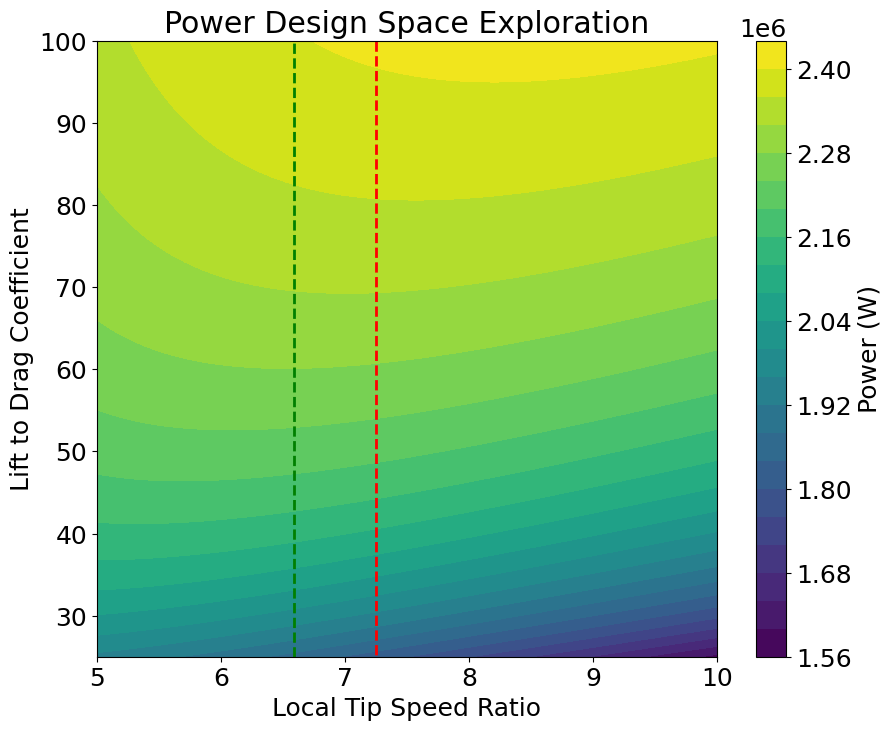

In [96]:
# let us fix x[1] (V0) and x[2] (D) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((x[...,3])*((x[...,0])+0.5/beta))
    return (np.pi/8)*CP*rho*(22)**2*(145)**2

# create meshgrid 
x0_range = np.linspace(5.0, 10.0, 100)
x3_range = np.linspace(25.0, 100.0, 100)
X0, X3 = np.meshgrid(x0_range, x3_range)

X = np.stack((X0, np.full_like(X0, 22), np.full_like(X0, 145), X3), axis=-1)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * 22 / 145
c3 = lambda x: 0.5 - 2 * 22**2 / (g * x[3])

# create a contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X0, X3, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Lift to Drag Coefficient')
plt.title('Power Design Space Exploration')

# plot constraints
plt.contour(X0, X3, c1([X0, X1, X2, X3]), levels=[0], colors='r', linestyles='--')
plt.contour(X0, X3, c2([X0, X1, X2, X3]), levels=[0], colors='g', linestyles='--')
plt.contour(X0, X3, c3([X0, X1, X2, X3]), levels=[0], colors='b', linestyles='--') # out of range anyways

# feasible region is right of red, left of green
plt.show()


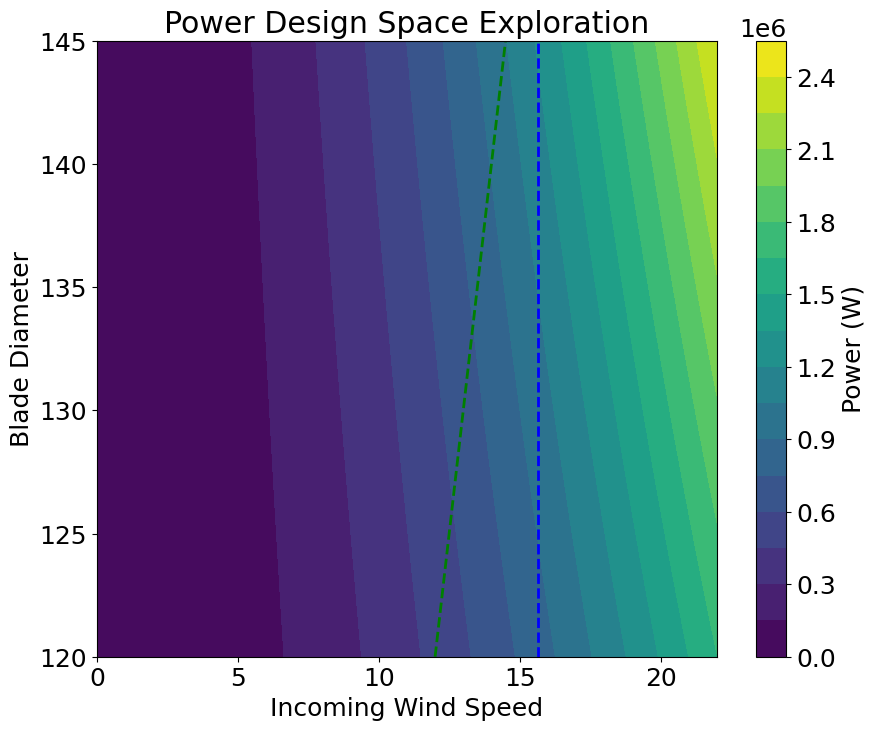

In [101]:
# let us fix x[0] (λr) and x[3] (cl/cd) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(10)*(10+(1.32+((10-8)/20)**2)/(beta**(2/3)))**-1-0.57*10**2/((100)*((10)+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[...,1])**2*(x[...,2])**2

# create meshgrid
x1_range = np.linspace(0.0, 22.0, 100)
x2_range = np.linspace(120.0, 145.0, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)

X = np.stack((np.full_like(X1, 10),X1, X2,np.full_like(X2, 100)), axis=-1)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * 10**5 -6*10**-6 * 10**4 + 0.0001 * 10**3 - 0.001 * 10**2 + 0.0048 * 10 + 0.3232) * (1-(1*10**-7 * 10**5 -6*10**-6 * 10**4 + 0.0001 * 10**3 - 0.001 * 10**2 + 0.0048 * 10 + 0.3232)))
c2 = lambda x: 2.0 - 2 * 10 * x[1] / x[2]
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * 100)

# create a contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X1, X2, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Incoming Wind Speed')
plt.ylabel('Blade Diameter')
plt.title('Power Design Space Exploration')


# plot constraints
#plt.contour(X1, X2, c1([X0, X1, X2, X3]), levels=[0], colors='r', linestyles='--') # only dependent on X0
plt.contour(X1, X2, c2([X0, X1, X2, X3]), levels=[0], colors='g', linestyles='--')
plt.contour(X1, X2, c3([X0, X1, X2, X3]), levels=[0], colors='b', linestyles='--') 

plt.show()

# feasible region is to lef

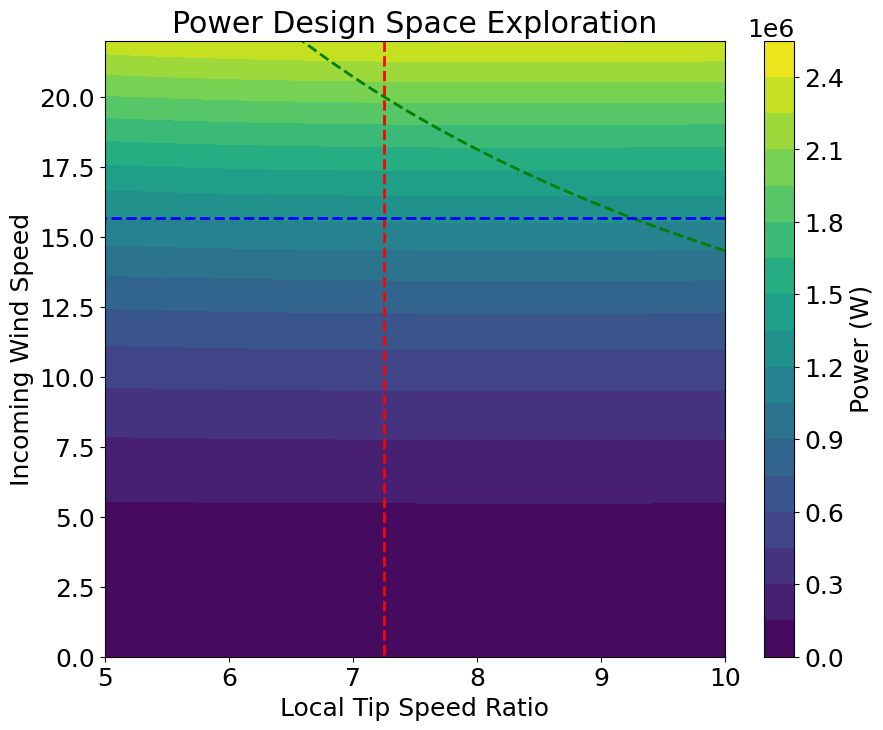

In [100]:
# let us fix x[2] (D) and x[3] (cl/cd) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((100)*((x[...,0])+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[...,1])**2*(145)**2

# create meshgrid
x0_range = np.linspace(5.0, 10.0, 1000)
x1_range = np.linspace(0.0, 22.0, 1000)
X0, X1 = np.meshgrid(x0_range, x1_range)


X = np.stack((X0, X1, np.full_like(X0, 145), np.full_like(X1, 100)), axis=-1)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * x[1] / 145
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * 100)


# create contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X0, X1, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Incoming Wind Speed')
plt.title('Power Design Space Exploration')


# plot constraints
plt.contour(X0, X1, c1([X0, X1, X2, X3]), levels=[0], colors='r', linestyles='--')
plt.contour(X0, X1, c2([X0, X1, X2, X3]), levels=[0], colors='g', linestyles='--')
plt.contour(X0, X1, c3([X0, X1, X2, X3]), levels=[0], colors='b', linestyles='--')

# feasible region is below blue, below green, and to right of red
plt.show()


In [56]:
# define constraints for SciPy minimize
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((x[...,3])*((x[...,0])+0.5/beta))
    return -1*(jnp.pi/8)*CP*rho*(x[...,1])**2*(x[...,2])**2


ineq_con1 = {'type': 'ineq',
             'fun': c1,
             'jac': grad(c1)}
ineq_con2 = {'type': 'ineq',
             'fun': c2,
             'jac': grad(c2)}
ineq_con3 = {'type': 'ineq',
             'fun': c3,
             'jac': grad(c3)}

k = 0

# define a callback function to store optimization histories
def callback_tr(x, state):
    global k
    k += 1
    
    xx_tr.append(x) # iterate xk
    fx_tr.append(state.fun) # function value
    c1x_tr.append(ineq_con1['fun'](x)) # constraint evaluation for c1 only
    c2x_tr.append(ineq_con2['fun'](x))
    c3x_tr.append(ineq_con3['fun'](x))
    
    constraint_vec_tr = [c1(x), c2(x), c3(x)]
    constraint_history_tr.append(constraint_vec_tr)
    
    print(f'xk_tr {x}, fk_tr {-1*state.fun}, c1 {c1(x)}, c2 {c2(x)}, c3 {c3(x)}')
    
# starting point
x0 = np.array([8.0, 10.0, 120.0, 25.0])

xx_tr = [] 
fx_tr = []
c1x_tr = [] 
c2x_tr = [] 
c3x_tr = [] 
constraint_history_tr = []

res = minimize(power, x0, method='trust-constr', jac=None,
               constraints=[ineq_con1, ineq_con2, ineq_con3],
               options=None,
               bounds=bounds, callback=callback_tr)

xk_tr [  8.  10. 120.  25.], fk_tr 249326.56506579308, c1 0.0020238960025599217, c2 156.89655172413794, c3 0.2961264016309888
xk_tr [  7.87296811  10.5718472  120.22239838  25.22776596], fk_tr 282526.28168926295, c1 0.0016401776139923774, c2 156.85197495356078, c3 0.27214280697764437
xk_tr [  6.55634916  17.30205466 120.58681767  25.62531819], fk_tr 806591.8762742606, c1 -0.0013898414426442018, c2 156.43533363321276, c3 -0.11031823713134759
xk_tr [  6.22341022  18.48120893 120.74871856  25.77529202], fk_tr 934459.6977716971, c1 -0.001914072986518911, c2 156.41357042045573, c3 -0.1963406393945163
xk_tr [  4.86173897  17.19264825 121.33820843  26.26442949], fk_tr 846438.7808079564, c1 -0.0031758215818283864, c2 156.84708733786243, c3 -0.10262416695720644
xk_tr [  4.93109096  16.49402226 124.04156883  27.69988627], fk_tr 823995.768068334, c1 -0.0031449021161431556, c2 156.8781582878811, c3 -0.05464377240678908
xk_tr [  4.96551187  16.1149597  145.100086    38.53005511], fk_tr 1147784.5472

xk_tr [  8.41043259  15.66045976 145.          99.99999999], fk_tr 1222154.6258289353, c1 0.003390394325207824, c2 156.18329322540546, c3 2.5733859487786503e-12
xk_tr [  8.41043259  15.66045976 145.          99.99999999], fk_tr 1222154.6258289353, c1 0.003390394325207824, c2 156.18329322540546, c3 2.5733859487786503e-12
xk_tr [  8.41043259  15.66045976 145.          99.99999999], fk_tr 1222154.6258289353, c1 0.003390394325207824, c2 156.18329322540546, c3 2.5733859487786503e-12
xk_tr [  8.41043259  15.66045976 145.          99.99999999], fk_tr 1222154.6258289353, c1 0.003390394325207824, c2 156.18329322540546, c3 2.5733859487786503e-12
xk_tr [  8.41043259  15.66045976 145.          99.99999999], fk_tr 1222154.6258289353, c1 0.003390394325207824, c2 156.18329322540546, c3 2.5733859487786503e-12
xk_tr [  8.41043259  15.66045976 145.          99.99999999], fk_tr 1222154.6258289353, c1 0.003390394325207824, c2 156.18329322540546, c3 2.5733859487786503e-12
xk_tr [  8.41043259  15.66045976 1

In [58]:
# COBYLA

# turn equality constraints to inequality constraints for COBYLA method

ineq_con1 = {'type': 'ineq',
             'fun': c1,
             'jac': grad(c1)}
ineq_con2 = {'type': 'ineq',
             'fun': c2,
             'jac': grad(c2)}
ineq_con2 = {'type': 'ineq',
             'fun': c3,
             'jac': grad(c3)}

k_c = 0  
# define a callback function to store optimization histories
def callback_c(x):
    global k_c
    k_c += 1
    
    xx_c.append(x) # iterate xk
    fk_c_value = power(x)
    fx_c.append(fk_c_value) # function value
    c1x_c.append(ineq_con1['fun'](x)) # constraint evaluation for c1 only
    c2x_c.append(ineq_con2['fun'](x))
    c3x_c.append(ineq_con3['fun'](x))
    
    constraint_vec_c = [c1(x), c2(x), c3(x)]
    constraint_history_c.append(constraint_vec_c)
    
    print(f'xk_c {x}, fk_c {-1*fk_c_value}, c1 {c1(x)}, c2 {c2(x)}, c3 {c3(x)}')

# starting point
x0 = np.array([7.0, 10.0, 120.0, 25.0])

xx_c = [] 
fx_c = []
c1x_c = [] 
c2x_c = [] 
c3x_c = [] 
constraint_history_c = []

constraints=[ineq_con1, ineq_con2, ineq_con3]

res = minimize(power, x0, method='COBYLA', jac=None,
               constraints=constraints,
               options=None,
               bounds=bounds, callback=callback_c)    

xk_c [  8.  10. 120.  25.], fk_c 249326.56506579308, c1 0.0020238960025599217, c2 156.89655172413794, c3 0.2961264016309888
xk_c [  7.  11. 120.  25.], fk_c 314714.93626301794, c1 -0.0005480279996398219, c2 156.93793103448274, c3 0.2533129459734964
xk_c [  7.  11. 121.  25.], fk_c 319982.04040464206, c1 -0.0005480279996398219, c2 156.93793103448274, c3 0.2533129459734964
xk_c [  7.  11. 121.  26.], fk_c 325032.97398791014, c1 -0.0005480279996398219, c2 156.93793103448274, c3 0.2533129459734964
xk_c [  7.21308095  11.96842927 121.09338745  26.08955468], fk_c 382919.54049939464, c1 -8.196450142405887e-05, c2 156.80925173613443, c3 0.2079647314607665
xk_c [  7.2732996   12.95924859 121.18074994  26.17333166], fk_c 449168.6000831772, c1 5.736592826333098e-05, c2 156.69991037817425, c3 0.1576103484472094
xk_c [  7.28996933  13.95553478 121.2596591   26.14317703], fk_c 520996.6169892736, c1 9.654081297405526e-05, c2 156.59675282113847, c3 0.1029419960872503
xk_c [  7.37074034  14.9378904  12

In [59]:
# SLSQP

k_slsqp = 0  
# define a callback function to store optimization histories
def callback_slsqp(x):
    global k_slsqp
    k_slsqp += 1
    
    xx_slsqp.append(x) # iterate xk
    fk_slsqp_value = power(x)
    fx_slsqp.append(fk_slsqp_value) # function value
    c1x_slsqp.append(ineq_con1['fun'](x)) 
    c2x_slsqp.append(ineq_con2['fun'](x))
    c3x_slsqp.append(ineq_con3['fun'](x))
    
    constraint_vec_slsqp = [c1(x), c2(x), c3(x)]
    constraint_history_slsqp.append(constraint_vec_slsqp)
    
    print(f'k_s {k_slsqp}, xk_slsqp {x}, fk_slsqp {-1*fk_slsqp_value}, c1 {c1(x)}, c2 {c2(x)}, c3 {c3(x)}')

x0 = np.array([7.0, 10.0, 120.0, 25.0])

xx_slsqp = [] 
fx_slsqp = []
c1x_slsqp = [] 
c2x_slsqp = [] 
c3x_slsqp = [] 

constraint_history_slsqp = []

constraints=[ineq_con1, ineq_con2, ineq_con3]

res = minimize(power, x0, method='SLSQP', jac=None,
               constraints=constraints,
               options=None,
               bounds=bounds, callback=callback_slsqp)

k_s 1, xk_slsqp [  7.25512297  17.29885701 145.         100.        ], fk_slsqp 1487985.0180949143, c1 1.494982319882876e-05, c2 156.2688919343286, c3 -0.11009266826434327
k_s 2, xk_slsqp [  7.25512297  17.29885701 145.         100.        ], fk_slsqp 1487985.0180949143, c1 1.494982319882876e-05, c2 156.2688919343286, c3 -0.11009266826434327


IndexError: list index out of range

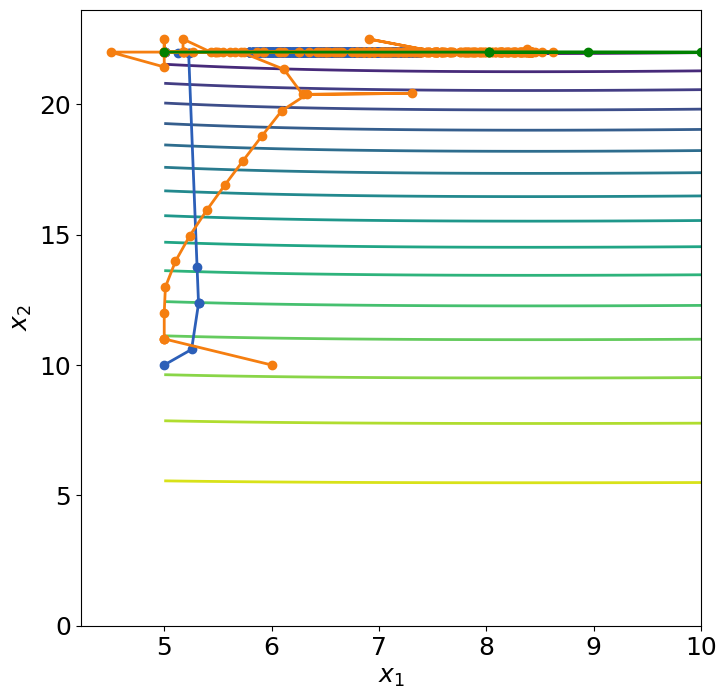

In [9]:
# plot contours for opt. trajectory
m =50
xv, yv = np.meshgrid(np.linspace(5,10, m), np.linspace(0,22,m))
x = np.column_stack((xv.reshape(-1,1), yv.reshape(-1,1)))


def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((100)*((x[...,0])+0.5/beta))
    return -1*(jnp.pi/8)*CP*rho*(x[...,1])**2*(145)**2

y = power(x)

plt.figure(figsize=(8,8))
plt.contour(xv, yv, y.reshape(m,m), levels=20)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

# plot trust-region algorithm
x1_tr = [x[0] for x in xx_tr]
x2_tr = [x[1] for x in xx_tr]

# plot COBYLA algorithm
x1_c = [x[0] for x in xx_c]
x2_c = [x[1] for x in xx_c]

# plot SLSQP algorithm
x1_slsqp = [x[0] for x in xx_slsqp]
x2_slsqp = [x[1] for x in xx_slsqp]

plt.plot(x1_tr, x2_tr, marker='o', c='#2c5fb8', label='Trust-Region Constrained')
plt.plot(x1_c, x2_c, marker='o', c='#F57E10', label='COBYLA')
plt.plot(x1_slsqp, x2_slsqp, marker='o', c='g', label='SLSQP')

x1 = np.linspace(5.0, 10.0, 1000)
x2 = np.linspace(0.0, 22.0, 1000)
x1v, x2v = np.meshgrid(x1, x2)
x = np.column_stack((x1v.reshape(-1,1), x2v.reshape(-1,1)))

plt.contour(x1v, x2v, c1([x1v, x2v]), levels=[0], colors='k', linestyles='--')
plt.contour(x1v, x2v, c2([x1v, x2v]), levels=[0], colors='k', linestyles='--')


plt.title('Optimization Trajectory')
plt.legend(fontsize='9')
plt.show()